# Simple Channel

Channels are just like lenses but that require a centerline. The centerline is a line that goes through the center of the channel. The width of the channel is the distance between the two lines that are parallel to the centerline and tangent to the edges of the channel. The depth of the channel is the distance the horizontal plane and the bottom of the channel. THe channel shape is represented by an extruded parabola that follows the centerline.

## 1. Creating a simulation grid

HyVR works with a 3D grid that represents the domain where the simulation will be performed.
A simple way of doing that is to create a 3D numpy array where each cell contains the properties of the media and the sedimentary structures that are present in that cell.
But any grid that can be reduced to a numpy array of cell coordinates can be used.

Since we use MODFLOW a lot. The numpy grid is done with the axis according to the MODFLOW convention.
That is, the first axis is the layer, the second is the row and the third is the column. Moreover, the first layer is the top layer and the last layer is the bottom layer, and the first row is the top row and the last row is the bottom row (like a matrix).

In [1]:
import numpy as np

# creating a grid according to the MODFLOW convention
xs = np.arange(0, 100.1, 0.5)
ys = np.arange(0, 80.1, 0.5)
zs = np.arange(0, 20.1, 0.4)
z, y, x = np.meshgrid(zs, ys, xs, indexing="ij")
z = np.flip(z, axis=0)
y = np.flip(y, axis=1)

## 2. Initialize the sedimentary attribute arrays

The objects that we simulate define a certain structure. This structure in a cell can be represented by the attributes:
- facies: the sedimentary facies assigned to each cell
- dip: the dip of the sedimentary structure
- dip_direction: the dip direction of the sedimentary structure

Since we modify these attributes in place when we create an object, we have to initialize these objects before. We can do that by creating a numpy array with the same shape as the simulation grid. The facies is an integer array with the facies code. (-1) facies code is used to represent a non assigned cell. The dip and dip_direction are float arrays with the dip and dip direction of the sedimentary structure in degrees.

In [48]:
facies = np.ones_like(x, dtype=np.int32) * (-1)
dip_array = np.zeros_like(x)
dip_dir_array = np.zeros_like(x)

## 3. Create a centerline with Ferguson's method.

Ferguson (1976) characterized channel centerlines as being heuritiscally modelled as a damped pendulum oscilator. Here we dont go into detail on the why, but we use this method to create realistic channel shapes. The method requires the following parameters:



In [39]:
from hyvr.tools import ferguson_curve

curve = ferguson_curve(
    h=0.05,
    k=np.pi / 60,
    eps_factor=(np.pi / 1) ** 2,
    flow_angle=0.0,
    s_max=150,
    xstart=-1,
    ystart=0.0,
    extra_noise=1e-4,
)

In [40]:
curve

(array([-1.        , -0.99938477, -0.99876953, ..., 38.24121519,
        38.240926  , 38.24079423]),
 array([ 0.00000000e+00, -5.33265199e-12, -2.29852656e-11, ...,
         6.21699502e+01,  6.22028341e+01,  6.22270270e+01]),
 array([ 1.        ,  1.        ,  1.        , ..., -0.01072202,
        -0.00686634, -0.00402722]),
 array([ 0.00000000e+00, -1.02710589e-08, -3.23969433e-08, ...,
         9.99942517e-01,  9.99976426e-01,  9.99991891e-01]),
 array([0.00000000e+00, 6.15234184e-04, 1.23046837e-03, ...,
        1.49942921e+02, 1.49975807e+02, 1.50000000e+02]))

It's good to check if the curve created is a good representation of the channel. We can do that by plotting the centerline and the channel shape.

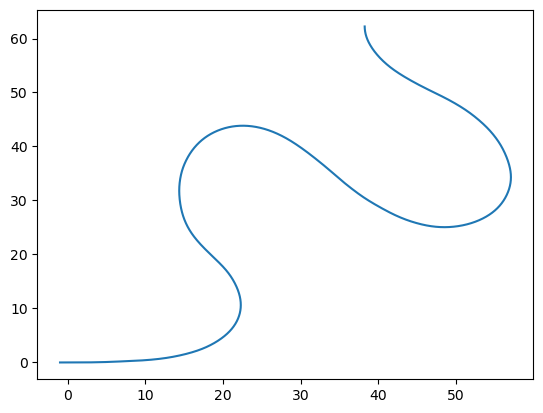

In [42]:
import matplotlib.pyplot as plt

plt.plot(curve[0], curve[1])

## 3. Create a simple lense that modifies the attribute arrays

A discontinuous sedimentary lens can be represented by a half-ellipsoid object. This object is the lower part of an ellipsoid cut in half in the horizontal direction. Itis defined by the center of the ellipsoid, the major and minor axis, in the horizontal direction and the height in the vertical direction, and the azimuth of the major axis.

In [49]:
from hyvr import channel

parabola_pars = np.array([2.0, 2.0])
channel(
    facies,
    dip_array,
    dip_dir_array,
    x=x,
    y=y,
    z=z,
    z_top=10.0,
    curve=np.c_[curve[0], curve[1]],
    parabola_pars=parabola_pars,
    facies=np.array([1]),
)

## Plotting

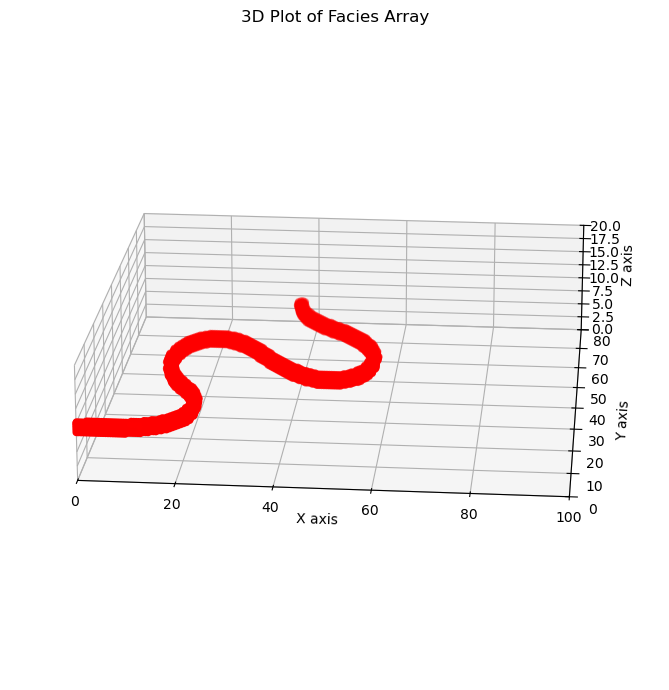

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Plotting the facies array
ax.scatter(x[facies == 1], y[facies == 1], z[facies == 1], c="r", marker="o")
ax.view_init(elev=20, azim=275)
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("3D Plot of Facies Array")
ax.set_xlim(0, 100)
ax.set_ylim(0, 80)
ax.set_zlim(0, 20)
ax.set_box_aspect([4, 4, 1])  # Aspect ratio is 2:2:1 to reduce vertical exaggeration
fig.tight_layout()